In [1]:
import numpy as np
import plotly.express as px
import pandas as pd
import plotly as plt
import plotly.graph_objects as go

In [2]:
data = pd.read_csv("benefits_of_cps_raw.csv")

In [3]:
all_benefit_names = data.columns.tolist()[1:9]
# Get the data in long format, so each row is a connection between a conservation practice and a benefit
long_data = data.melt(id_vars=['CP Name'], value_vars=all_benefit_names, var_name = "Benefit")

In [4]:
long_data

,CP Name,Benefit,value
0,CP #382 | Fence | (Feet),Wildlife/Ecosystem Connectivity,NaN
1,CP #580 | Streambank and Shoreline Protection ...,Wildlife/Ecosystem Connectivity,x
2,CP #561 | Heavy Use Area Protection | (Sq. Ft.),Wildlife/Ecosystem Connectivity,NaN
3,CP #516 | Livestock Pipeline | (Feet),Wildlife/Ecosystem Connectivity,NaN
4,CP #528 | Prescribed Grazing (IRA) | (Acres),Wildlife/Ecosystem Connectivity,NaN
...,...,...,...
411,CP #642 | Water Well | (Num.),Riparian Condition,NaN
412,CP #378 | Pond | (Num.),Riparian Condition,NaN
413,CP #646 | Shallow Water Development and Manage...,Riparian Condition,NaN
414,CP #412 | Grassed Waterway (IRA) | (Acres),Riparian Condition,NaN


In [5]:
# There are multiple "levels" of connection, for now we are condensing to connected or not
long_data['value'] = long_data['value'].apply(lambda x: 0 if pd.isnull(x) else 1)
# Cleaning names of benefits and conservation practices
long_data['CP Name'] = long_data['CP Name'].apply(lambda x: x.split('|')[1].strip())
long_data['Benefit'] = long_data['Benefit'].apply(lambda x: x.strip())

In [6]:
set(long_data['Benefit'])

{'Aquatic Habitat',
 'Biodiversity',
 'Riparian Condition',
 'Streambank and Shoreline condition',
 'Terrestrial Habitat',
 'Water Quality',
 'Wetands Conservation',
 'Wildlife/Ecosystem Connectivity'}

In [7]:
# Custom colors based on all benefits present in the table
colors = {'Aquatic Habitat': '#1691f5',
          'Biodiversity': '#dc78fa',
 'Riparian Condition': '#0fd697',
 'Streambank and Shoreline condition': '#e6da73',
 'Terrestrial Habitat': '#01912a',
 'Water Quality': '#11f5f5',
 'Wetands Conservation': '#71c708',
 'Wildlife/Ecosystem Connectivity': '#e33f22'}

In [8]:
# Sankey diagram expects a list of strings (labels), and the sources and targets are set by
# indicies in that list of strings
labels = list(set(pd.concat([long_data['CP Name'], long_data['Benefit']])))
long_data['source_idx'] = long_data['Benefit'].apply(lambda x: labels.index(x))
long_data['target_idx'] = long_data['CP Name'].apply(lambda x: labels.index(x))
long_data['color'] = long_data['Benefit'].apply(lambda x: colors[x])

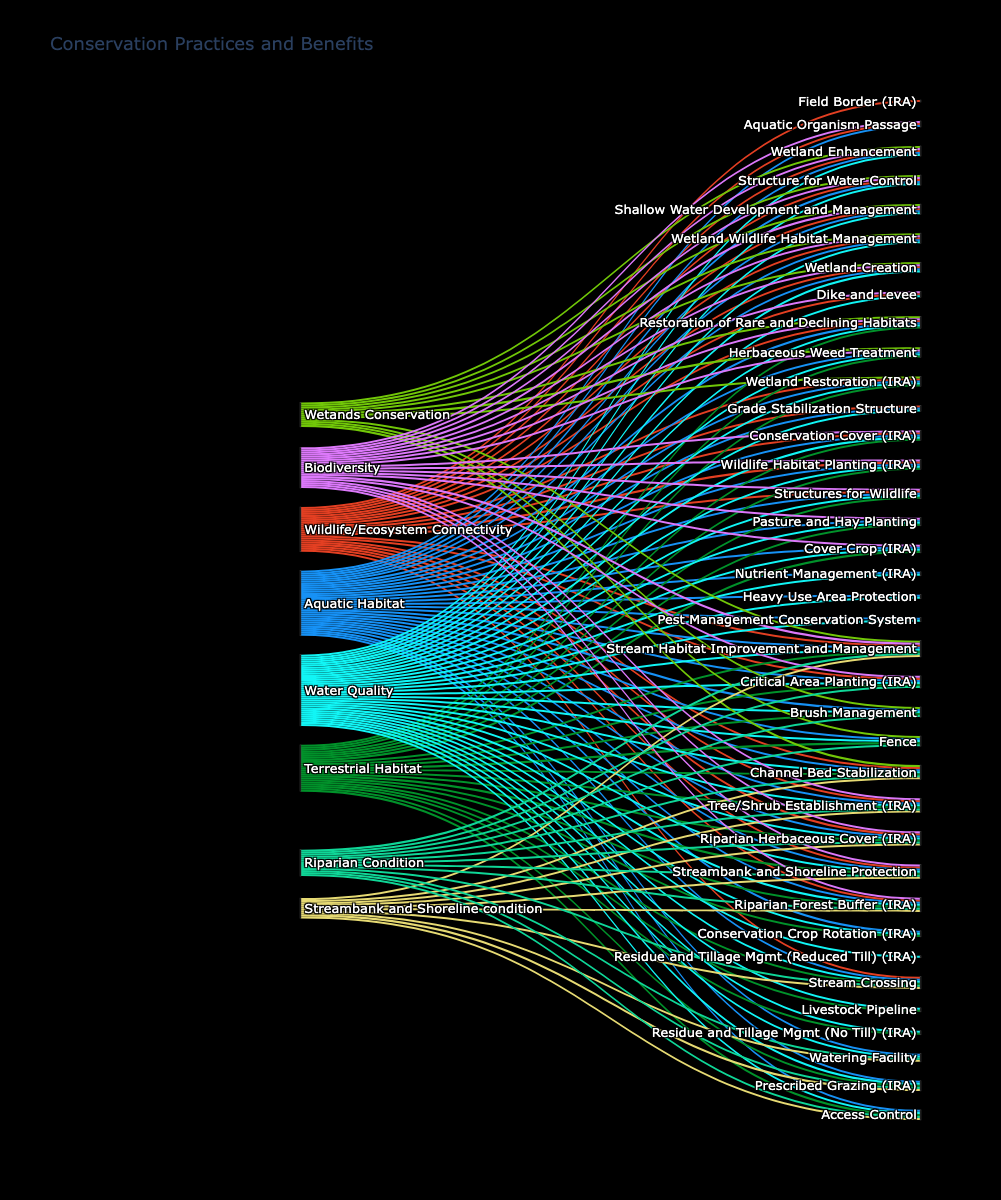

In [15]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      thickness = 1,
      color = 'black',
      label = labels,
      hoverinfo='none', 
    ),
    link = dict(
      source = long_data['source_idx'],
      target = long_data['target_idx'],
      value = long_data['value'],
      color = long_data['color'],
      hovertemplate = '%{source.label} benefits %{target.label}<extra></extra>',
      hoverlabel = dict(bgcolor = 'black', font=dict(size=14)),
      hovercolor = 'white',
  ))])

fig.update_layout(title_text="Conservation Practices and Benefits", 
                  font_size=13, 
                  height=1200, 
                  margin=dict(l=300), 
                  paper_bgcolor='black')
fig.update_traces(textfont_color='white', selector=dict(type='sankey'))
js = '''
const TEXTPAD = 3; // constant used by Plotly.js

function sankeyNodeLabelsAlign(position, forcePos) {
  const textAnchor = {left: 'end', right: 'start', center: 'middle'}[position];
  const nodes = gd.getElementsByClassName('sankey-node');

  for (const node of nodes) {
    const d = node.__data__;
    const label = node.getElementsByClassName('node-label').item(0);

    // Ensure to reset any previous modifications
    label.setAttribute('x', 0);

    if (!d.horizontal)
      continue;

    // This is how Plotly's default text positioning is computed (coordinates
    // are relative to that of the cooresponding node).
    const padX = d.nodeLineWidth / 2 + TEXTPAD;
    const posX = padX + d.visibleWidth;
    let x;

    switch (position) {
      case 'left':
        if (d.left || d.node.originalLayer === 0 && !forcePos)
          continue;
        x = -posX - padX;
        break;

      case 'right':
        if (!d.left || !forcePos)
          continue;
        x = posX + padX;
        break;

      case 'center':
        if (!forcePos && (d.left || d.node.originalLayer === 0))
          continue;
        x = (d.nodeLineWidth + d.visibleWidth)/2 + (d.left ? padX : -posX);
        break;
    }

    label.setAttribute('x', x);
    label.setAttribute('text-anchor', textAnchor);
  }
}

const gd = document.getElementById('{plot_id}');
const position = 'left';
const forcePos = true;

gd.on('plotly_afterplot', sankeyNodeLabelsAlign.bind(gd, position, forcePos));
gd.emit('plotly_afterplot');
'''

fig.show(post_script=[js])

In [10]:
fig.write_html("sankey.html", post_script=[js])